In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
import tensorflow as tf

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 0.0001
EPOCHS = 30
BS = 32

In [6]:
DIRECTORY = 'dataset/'
CATEGORIES = ["with_mask", "without_mask"]

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


c:\Users\INDIA\anaconda3\envs\new_env\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [9]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\INDIA\AppData\Local\Temp\ipykernel_13400\4269477345.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
# compile our model
print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR // EPOCHS)
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/30


c:\Users\INDIA\anaconda3\envs\new_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7607 - loss: 0.5470 - val_accuracy: 0.9870 - val_loss: 0.1403
Epoch 2/30
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1:31 969ms/step - accuracy: 0.8438 - loss: 0.3282

c:\Users\INDIA\anaconda3\envs\new_env\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.1658 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9639 - loss: 0.1603 - val_accuracy: 0.9896 - val_loss: 0.0773
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.0771 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9786 - loss: 0.0917 - val_accuracy: 0.9922 - val_loss: 0.0562
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9688 - loss: 0.0712 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9783 - loss: 0.0844 - val_accuracy: 0.9883 - val_loss: 0.0467
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9688 - loss: 0.0268 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9810 - loss: 0.0692 - val_acc

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [15]:

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model.h5")

[INFO] saving mask detector model...


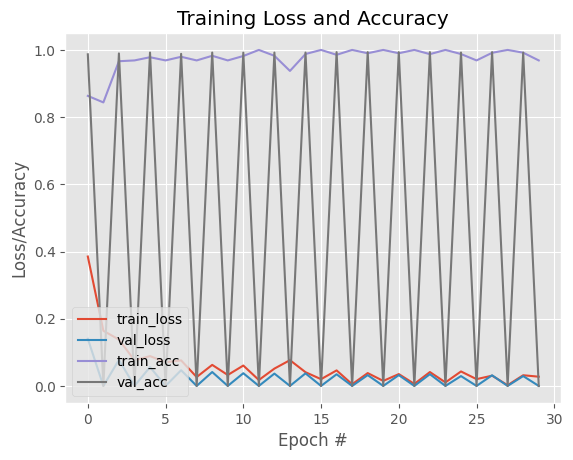

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")